In [1]:
import warnings
warnings.filterwarnings('ignore')

import tensorflow.keras as keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential, load_model, Model
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.applications.xception import Xception

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

from utils import load_data, load_test_data
from utils import num_classes, epochs, batch_size

In [2]:
X_train, y_train, X_valid, y_valid = load_data(Gray2RGB=True, img_size = 299,
                                               mean_proc=None, test_size=0.1)

# Xception Fine Tuning

In [3]:
model_name = 'Xception-Fine-Tune'

img_rows, img_cols, img_channel = 299, 299, 3
base_model = Xception(weights='imagenet', include_top=False,
                         input_shape=(img_rows, img_cols, img_channel))

x = base_model.output
x = GlobalAveragePooling2D(data_format='channels_last')(x)
x = Dropout(0.5)(x)
predictions = Dense(num_classes, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)

model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 299, 299, 3) 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 149, 149, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 149, 149, 32) 128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, 149, 149, 32) 0           block1_conv1_bn[0][0]            
______________________________________________________________________________________________

In [4]:
datagen = ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest')

optimizer = keras.optimizers.Adam(lr=10e-6)

model_path = './saved_models/{}.h5'.format(model_name)

checkpoint = ModelCheckpoint(model_path, monitor='val_loss', save_best_only=True, verbose=1)
earlystop = EarlyStopping(monitor='val_loss', patience=5, verbose=1)

model.compile(loss='categorical_crossentropy',
              optimizer=optimizer, metrics=['accuracy'])

batch_size = 10
epochs = 5
model_history = model.fit_generator(datagen.flow(X_train, y_train, batch_size = batch_size),
                                    #steps_per_epoch = 100 ,
                                    epochs = epochs,
                                    validation_data = (X_valid, y_valid),
                                    callbacks = [checkpoint, earlystop])

Epoch 1/5
47/48 [============================>.] - ETA: 0s - loss: 2.6314 - accuracy: 0.0985
Epoch 00001: val_loss improved from inf to 2.56888, saving model to ./saved_models/Xception-Fine-Tune.h5
48/48 [==============================] - 18s 380ms/step - loss: 2.6338 - accuracy: 0.0964 - val_loss: 2.5689 - val_accuracy: 0.1296
Epoch 2/5
47/48 [============================>.] - ETA: 0s - loss: 2.5537 - accuracy: 0.1242
Epoch 00002: val_loss improved from 2.56888 to 2.47965, saving model to ./saved_models/Xception-Fine-Tune.h5
48/48 [==============================] - 18s 383ms/step - loss: 2.5530 - accuracy: 0.1216 - val_loss: 2.4796 - val_accuracy: 0.1667
Epoch 3/5
47/48 [============================>.] - ETA: 0s - loss: 2.3973 - accuracy: 0.2163
Epoch 00003: val_loss improved from 2.47965 to 2.38226, saving model to ./saved_models/Xception-Fine-Tune.h5
48/48 [==============================] - 18s 381ms/step - loss: 2.3965 - accuracy: 0.2180 - val_loss: 2.3823 - val_accuracy: 0.2407
Ep

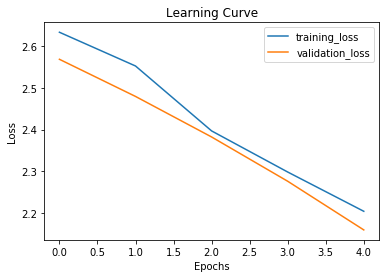

In [5]:
training_loss = model_history.history['loss']
val_loss = model_history.history['val_loss']

plt.plot(training_loss, label="training_loss")
plt.plot(val_loss, label="validation_loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Learning Curve")
plt.legend(loc='best')
plt.show()

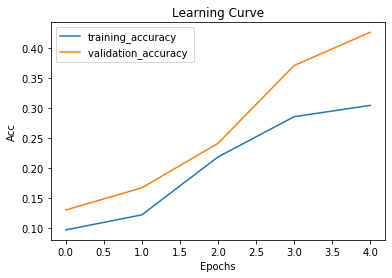

In [6]:
training_acc = model_history.history['accuracy']
val_acc = model_history.history['val_accuracy']

plt.plot(training_acc, label="training_accuracy")
plt.plot(val_acc, label="validation_accuracy ")
plt.xlabel("Epochs")
plt.ylabel("Acc")
plt.title("Learning Curve")
plt.legend(loc='best')
plt.show()

In [7]:
X_test, X_id = load_test_data(Gray2RGB=True, mean_proc=None, img_size=299)

model = load_model(model_path)

scores = model.evaluate(X_valid, y_valid, verbose=1)
print('Validation loss:', scores[0])
print('Validation accuracy:', scores[1])

y_test_pred_prob = model.predict(X_test)
y_test_pred = y_test_pred_prob.argmax(axis=-1)
y_test_pred_df = pd.DataFrame({'id': np.array(X_id), 'class':y_test_pred}).sort_values(by='id')
y_test_pred_df.to_csv('./submissions/{}.csv'.format(model_name), index=False)

54/1 [==================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

# Vilidation Set 預測錯誤分析

In [8]:
X_valid_prediction = model.predict(X_valid)
prediction_X_valid = X_valid_prediction.argmax(axis=-1)

In [9]:
prediction_X_valid

array([8, 1, 3, 3, 0, 6, 6, 0, 6, 4, 8, 1, 3, 3, 1, 1, 0, 6, 8, 0, 0, 6,
       8, 8, 3, 3, 4, 3, 3, 6, 1, 6, 8, 1, 1, 1, 3, 1, 3, 3, 3, 3, 3, 4,
       3, 6, 3, 3, 7, 8, 3, 3, 4, 3])

In [10]:
def one_hot_to_indices(data):
    indices = []
    for el in data:
        indices.append(list(el).index(1))
    return indices

y_valid_1 = one_hot_to_indices(y_valid)
y_valid_1 = np.array(y_valid_1)
y_valid_1.shape 

(54,)

In [11]:
y_valid_1

array([8, 5, 3, 7, 0, 4, 6, 0, 1, 6, 8, 5, 1, 6, 3, 1, 0, 7, 8, 6, 0, 2,
       8, 8, 4, 3, 8, 5, 3, 6, 5, 7, 8, 1, 1, 5, 6, 1, 8, 6, 9, 7, 7, 6,
       3, 5, 7, 3, 7, 2, 3, 7, 6, 9])

In [12]:
import pandas as pd
pd.crosstab(y_valid_1,prediction_X_valid, rownames=['label'],colnames=['predict'])

predict,0,1,3,4,6,7,8
label,,,,,,,
0,4,0,0,0,0,0,0
1,0,4,1,0,1,0,0
2,0,0,0,0,1,0,1
3,0,1,6,0,0,0,0
4,0,0,1,0,1,0,0
5,0,4,1,0,1,0,0
6,1,0,3,3,2,0,0
7,0,0,5,0,2,1,0
8,0,0,1,1,0,0,6


In [13]:
df = pd.DataFrame({'label':y_valid_1 , 'predict':prediction_X_valid}) 

In [14]:
class_mapping = {'18': 0,'Ellie': 1,'Prof.Kang': 2,'Rockman': 3,'Yoshit': 4,'lala': 5, 'tan': 6,'tim': 7, 'wwk': 8,'Jerry': 9}
inv_mapping = {v: k for k , v in class_mapping.items()}
inv_mapping

{0: '18',
 1: 'Ellie',
 2: 'Prof.Kang',
 3: 'Rockman',
 4: 'Yoshit',
 5: 'lala',
 6: 'tan',
 7: 'tim',
 8: 'wwk',
 9: 'Jerry'}

In [15]:
label_1 = []
for i in range(len(df)) :
    aa = inv_mapping[df['label'][i]]
    label_1.append(aa)  

In [16]:
label_1 = pd.DataFrame(label_1 , columns = ['label_1'])
df = pd.concat([df , label_1] , axis=1)
df

,label,predict,label_1
0,8,8,wwk
1,5,1,lala
2,3,3,Rockman
3,7,3,tim
4,0,0,18
5,4,6,Yoshit
6,6,6,tan
7,0,0,18
8,1,6,Ellie
9,6,4,tan


In [17]:
predict_1 = []
for i in range(len(df)) :
    aa = inv_mapping[df['predict'][i]]
    predict_1.append(aa)  

In [18]:
predict_1 = pd.DataFrame(predict_1 , columns = ['predict_1'])
df = pd.concat([df , predict_1] , axis=1)
df

,label,predict,label_1,predict_1
0,8,8,wwk,wwk
1,5,1,lala,Ellie
2,3,3,Rockman,Rockman
3,7,3,tim,Rockman
4,0,0,18,18
5,4,6,Yoshit,tan
6,6,6,tan,tan
7,0,0,18,18
8,1,6,Ellie,tan
9,6,4,tan,Yoshit


In [19]:
pd.crosstab(df['label_1'],df['predict_1'], rownames=['label'],colnames=['predict'])

predict,18,Ellie,Rockman,Yoshit,tan,tim,wwk
label,,,,,,,
18,4,0,0,0,0,0,0
Ellie,0,4,1,0,1,0,0
Jerry,0,0,2,0,0,0,0
Prof.Kang,0,0,0,0,1,0,1
Rockman,0,1,6,0,0,0,0
Yoshit,0,0,1,0,1,0,0
lala,0,4,1,0,1,0,0
tan,1,0,3,3,2,0,0
tim,0,0,5,0,2,1,0


In [20]:
df_wrong = df[df.label_1!=df.predict_1]
df_wrong 

,label,predict,label_1,predict_1
1,5,1,lala,Ellie
3,7,3,tim,Rockman
5,4,6,Yoshit,tan
8,1,6,Ellie,tan
9,6,4,tan,Yoshit
11,5,1,lala,Ellie
12,1,3,Ellie,Rockman
13,6,3,tan,Rockman
14,3,1,Rockman,Ellie
17,7,6,tim,tan


In [21]:
wrongindex = df_wrong.index
wrongindex

Int64Index([ 1,  3,  5,  8,  9, 11, 12, 13, 14, 17, 19, 21, 24, 26, 27, 30, 31,
            35, 36, 38, 39, 40, 41, 42, 43, 45, 46, 49, 51, 52, 53],
           dtype='int64')

In [22]:
df_wrong['label_1'].iloc[1] , df_wrong['predict_1'].iloc[1] , wrongindex[1]

('tim', 'Rockman', 3)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

<Figure size 216x216 with 0 Axes>

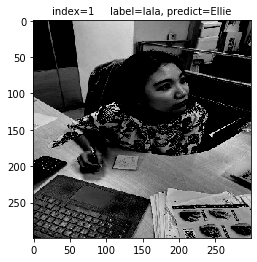

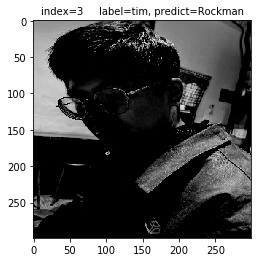

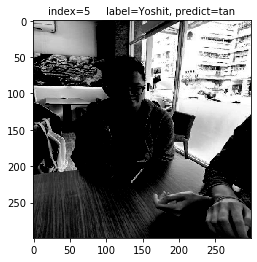

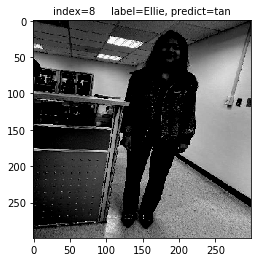

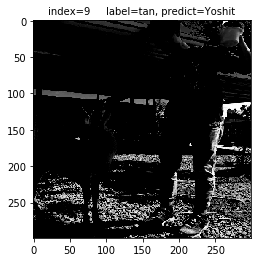

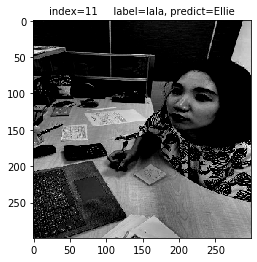

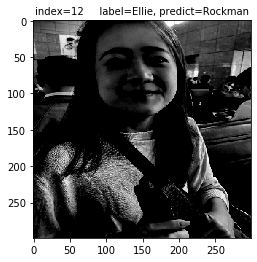

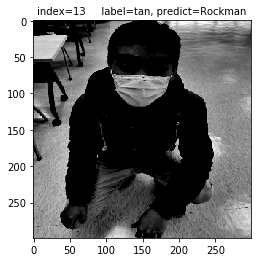

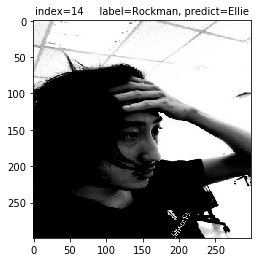

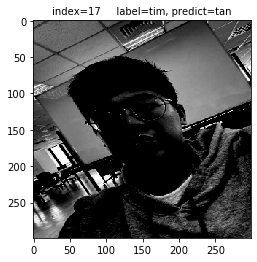

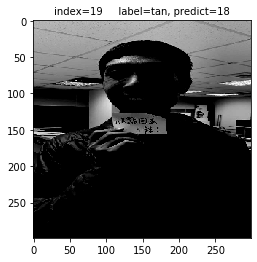

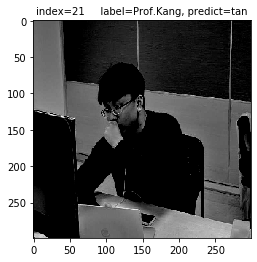

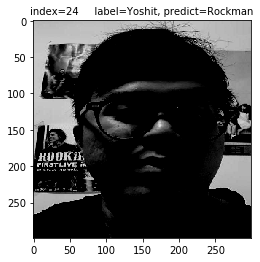

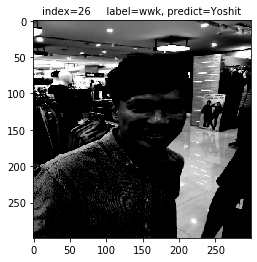

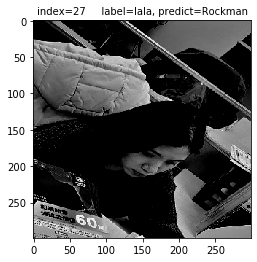

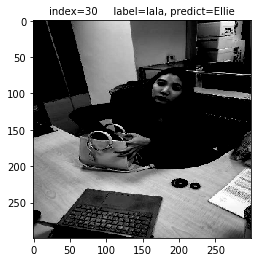

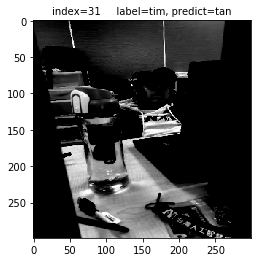

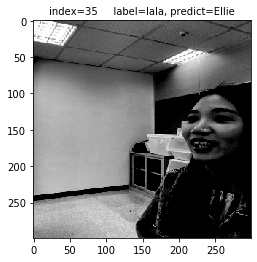

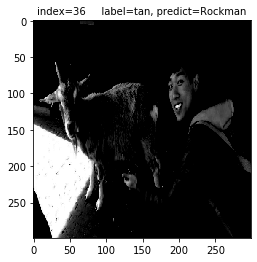

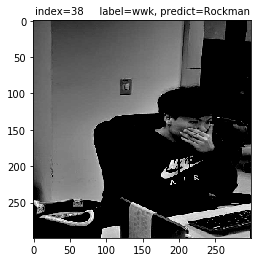

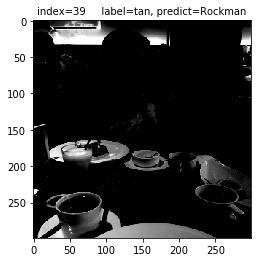

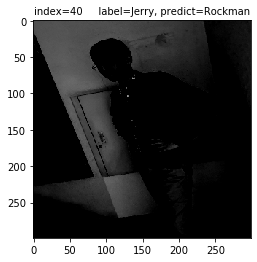

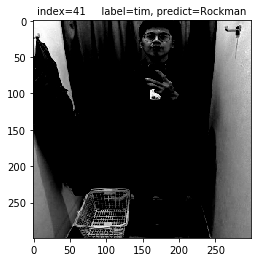

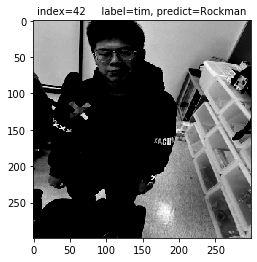

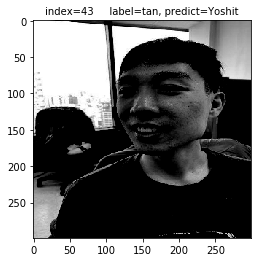

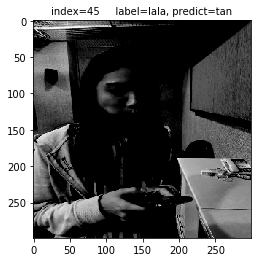

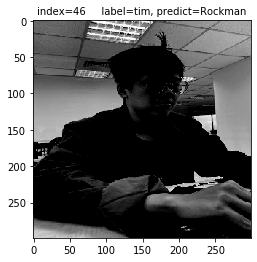

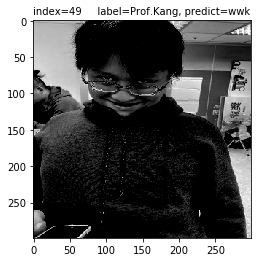

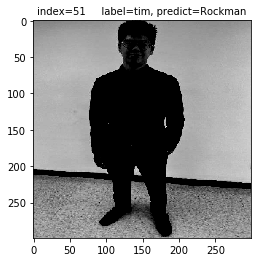

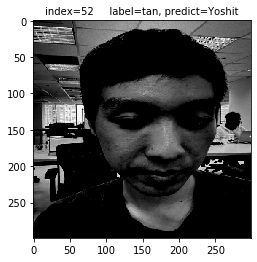

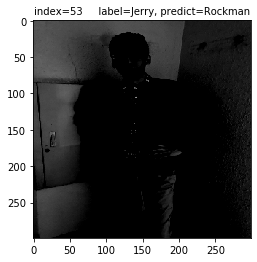

In [23]:
import matplotlib.pyplot as plt
fig = plt.gcf()

for i in range(len(wrongindex)) :
    plt.figure()
    plt.subplot(2,1+len(wrongindex)/2,1+i)
    
    fig.set_size_inches(3, 3)
    ax = plt.axes()
    plt.imshow(X_valid[wrongindex[i]])
   
    title ="index=" +str(wrongindex[i])
    ax.set_title(title,fontsize=10)       
    title+="     label=" +str(df_wrong['label_1'].iloc[i])
    ax.set_title(title,fontsize=10)
    title+=", predict=" +str(df_wrong['predict_1'].iloc[i])
    ax.set_title(title,fontsize=10) 

In [24]:
pd.crosstab(df['label_1'],df['predict_1'], rownames=['label'],colnames=['predict'])

predict,18,Ellie,Rockman,Yoshit,tan,tim,wwk
label,,,,,,,
18,4,0,0,0,0,0,0
Ellie,0,4,1,0,1,0,0
Jerry,0,0,2,0,0,0,0
Prof.Kang,0,0,0,0,1,0,1
Rockman,0,1,6,0,0,0,0
Yoshit,0,0,1,0,1,0,0
lala,0,4,1,0,1,0,0
tan,1,0,3,3,2,0,0
tim,0,0,5,0,2,1,0


In [25]:
mapping = {'18': 0,'Ellie': 1,'Prof.Kang': 2,'Rockman': 3,'Yoshit': 4,'lala': 5, 'tan': 6,'tim': 7, 'wwk': 8,'Jerry': 9}

Text(91.68, 0.5, 'label')

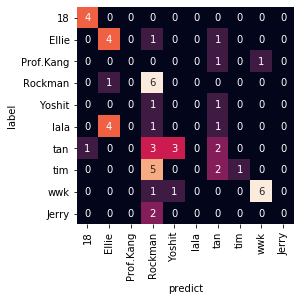

In [26]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
mat = confusion_matrix(y_valid_1 , prediction_X_valid)
sns.heatmap(mat,square=True,annot=True,fmt='d',cbar=False,
           xticklabels=mapping , yticklabels=mapping)
plt.xlabel('predict')
plt.ylabel('label')